In [28]:
!pip install --upgrade "jax[cuda]==0.3.15" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jaxlib[cuda]==0.3.15" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install ./jaxns
!pip install git+https://github.com/adam-coogan/jaxinterp2d.git
!pip install corner
!pip install healpy
!pip install arviz

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Defaulting to user installation because normal site-packages is not writeable
Processing ./jaxns
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for jaxns: filename=jaxns-0.0.7-py3-none-any.whl size=95014 sha256=ef1414c2a76740a95a01c23fdb838aa41b46457c487adab7c9629808c37670a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-telts31b/wheels/9c/7d/d8/5e3476e7cb49b9318aa6190f6a40157f09df1e693aa0b4ea91
Successfully built jaxns
  Attempting uninstall: jaxns
    Found existing installation: jaxns 0.0.7
    Uninstalling jaxns-0.

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99'

In [2]:
import jax

import jaxns
from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns.utils import summary, resample
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

from jax.config import config
config.update("jax_enable_x64", True)
config.update('jax_default_matmul_precision', jax.lax.Precision.HIGHEST)

In [3]:
import h5py

with h5py.File('standard-sirens64_9000_approx.h5', 'r') as f:
    nside = f.attrs['nside']
    n0fid = f.attrs['n0fid']
    H0Planck = f.attrs['H0fid']
    zgrid1 = jnp.asarray(f['zgrid'])
    Om0grid = jnp.asarray(f['Om0grid'])
    deltagrid = jnp.asarray(f['deltagrid'])
    fs1 = jnp.asarray(f['fs'])
    vals1 = jnp.asarray(f['pcat'])

with h5py.File('standard-sirens64_10000_approx.h5','r') as f:
    zgrid2 = jnp.asarray(f['zgrid'])
    fs2 = jnp.asarray(f['fs'])
    vals2 = jnp.asarray(f['pcat'])

2023-06-21 11:40:17.945886: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
from jaxinterp2d import interp2d, CartesianGrid

Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid2).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid2))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid2,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid2,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 138.78it/s]


In [5]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)


In [6]:
from jaxinterp2d import interp2d

vals1 = jnp.asarray(vals1)
vals2=jnp.asarray(vals2)
pixgrids = jnp.arange(npix)
vv1 = vals1.reshape(len(pixgrids),len(zgrid1))
vv2=vals2.reshape(len(pixgrids),len(zgrid2))

@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(z,H0Planck,Om0)*(1+z)**(gamma-1)
    return dV/jnp.trapz(dV,z)


@jit
def PriorUniverse1(z,pix,H0,Om0,gamma):
    pcat = interp2d(pix,zgrid1,pixgrids,zgrid1,vv1)*(1+zgrid1)**(gamma-1)*dV_of_z_normed(zgrid1,Om0,1)
    pcat = pcat/jnp.trapz(pcat,zgrid1)
    prob = jnp.where(~jnp.isnan(pcat), pcat, 0)
    return jnp.interp(z,zgrid1,prob)

@jit
def PriorUniverse2(z,pix,H0,Om0,gamma):
    pcat = interp2d(pix,zgrid2,pixgrids,zgrid2,vv2)*(1+zgrid2)**(gamma-1)*dV_of_z_normed(zgrid2,Om0,1)
    pcat = pcat/jnp.trapz(pcat,zgrid2)
    prob = jnp.where(~jnp.isnan(pcat), pcat, 0)
    return jnp.interp(z,zgrid2,prob)

#PriorUniverse_vmap = jit(vmap(PriorUniverse, in_axes=(None,0,None,None,None), out_axes=0))

In [7]:
ztest = np.linspace(0,3,100)
print(len(pixgrids))

49152


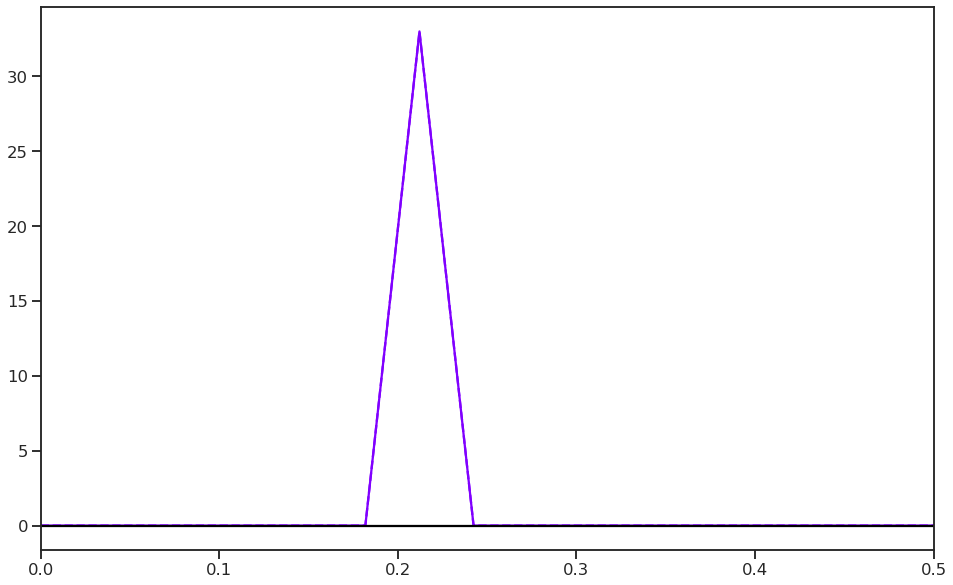

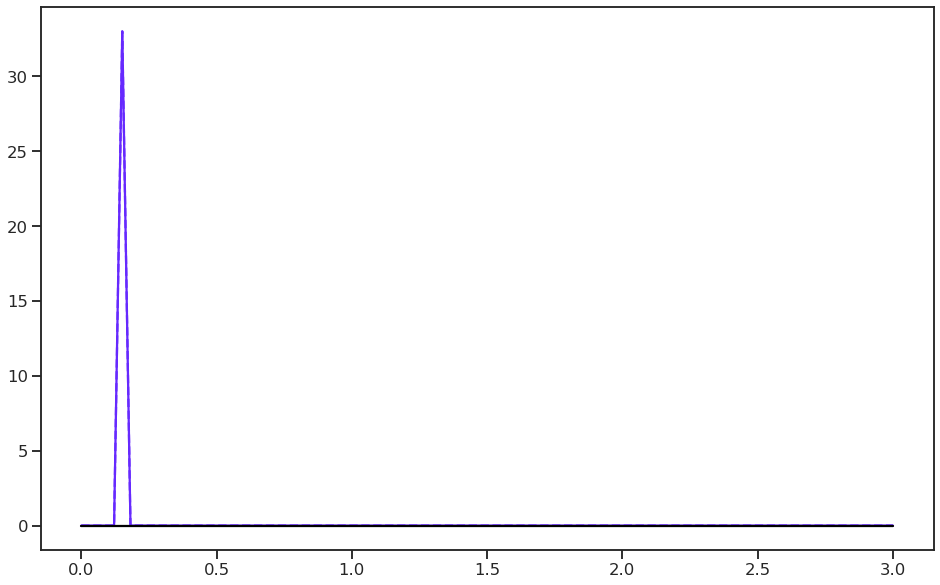

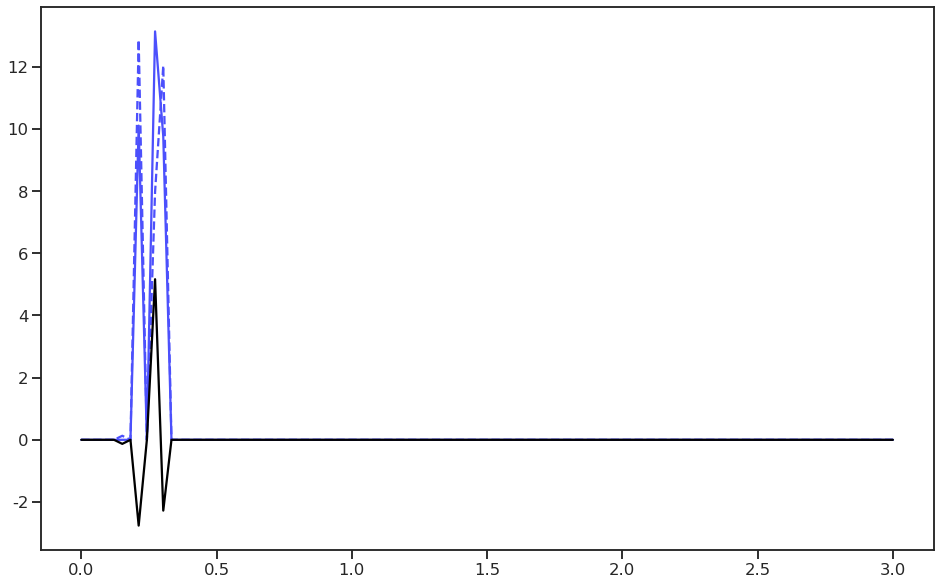

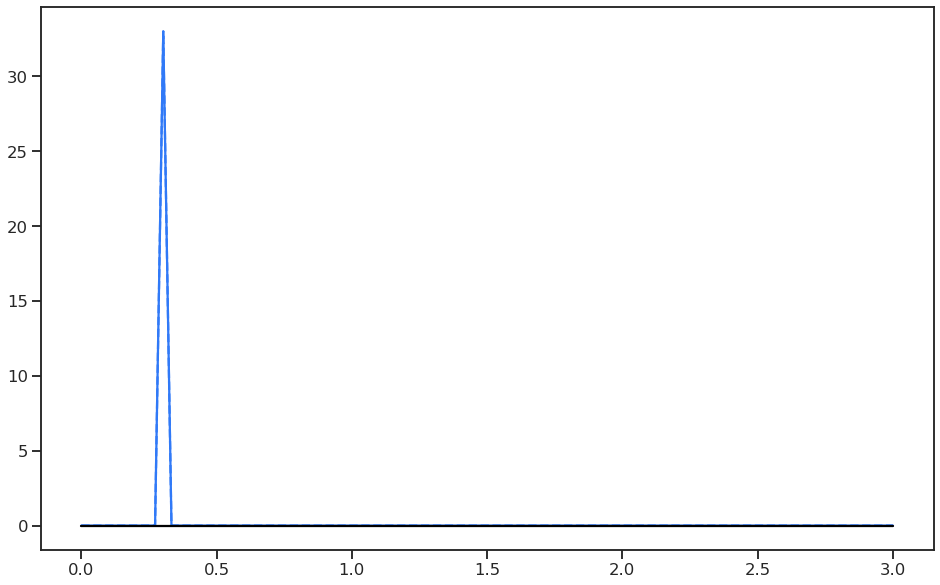

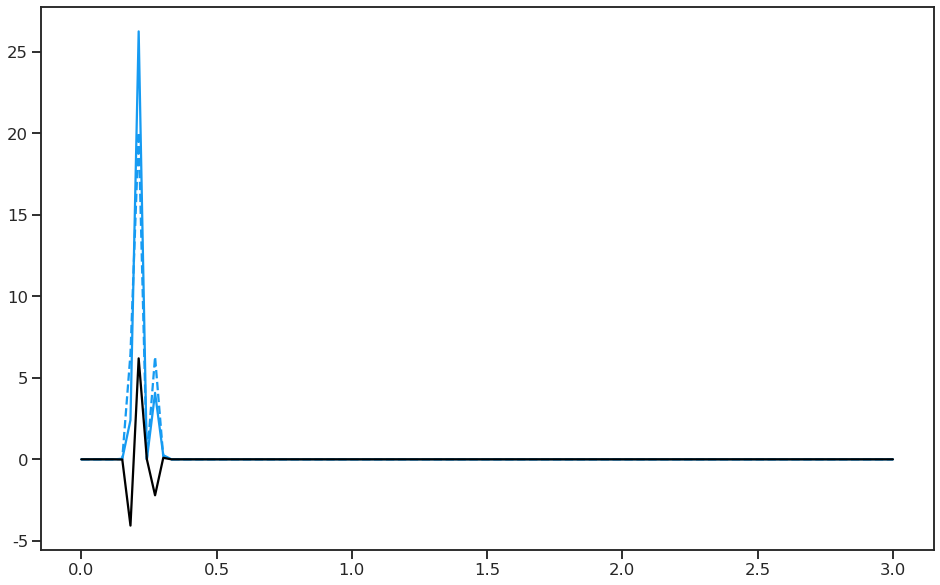

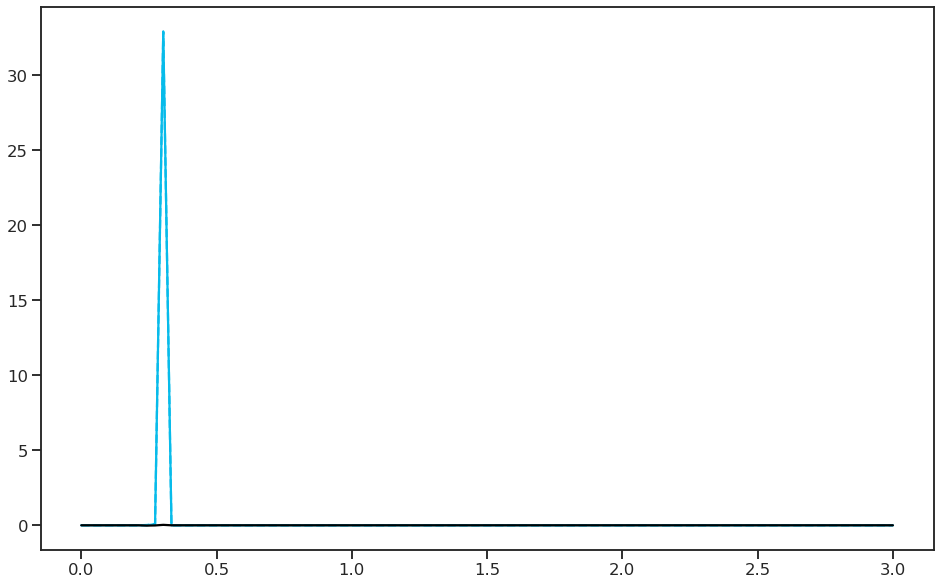

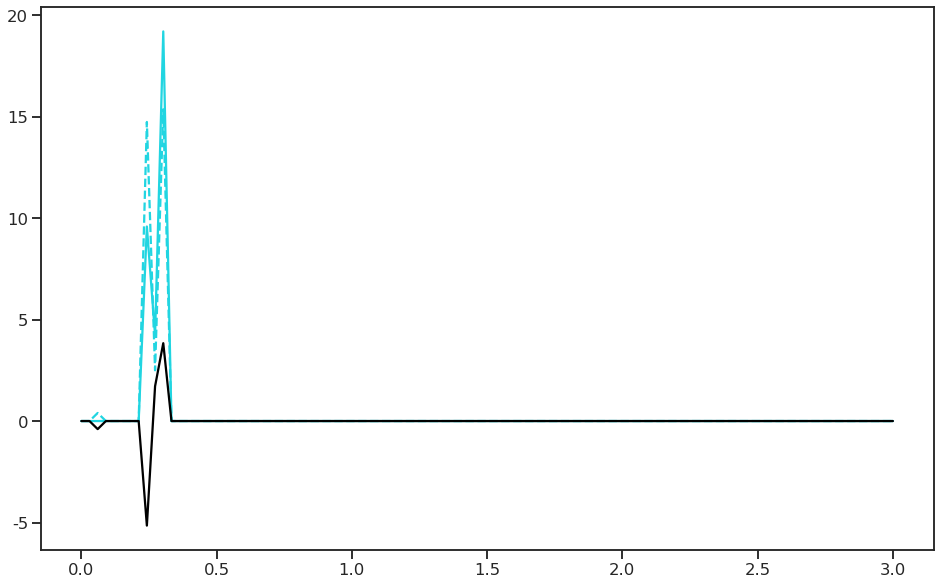

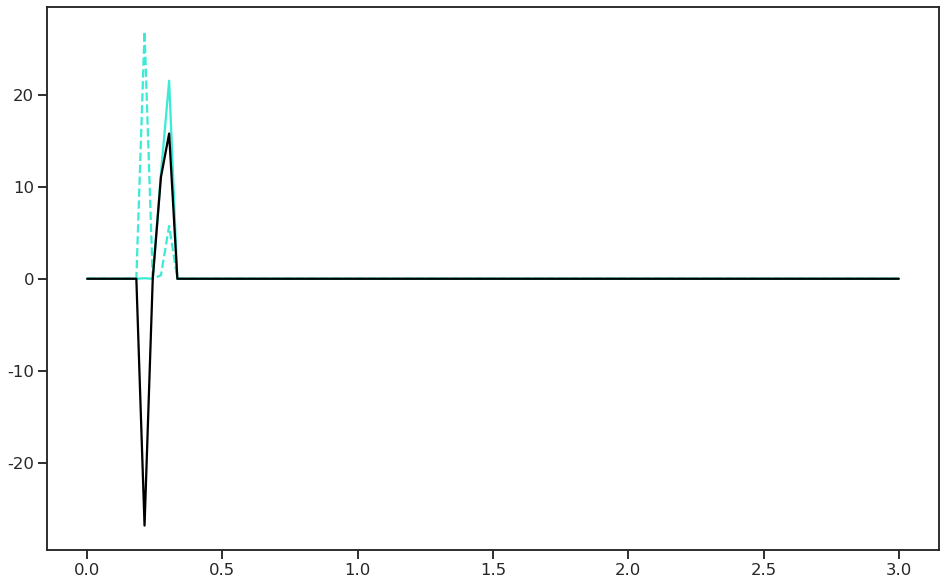

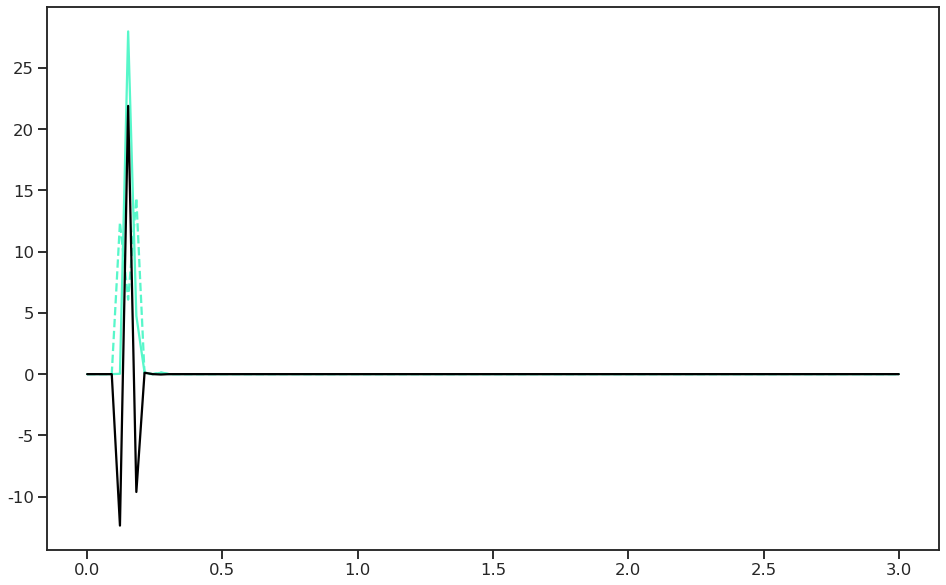

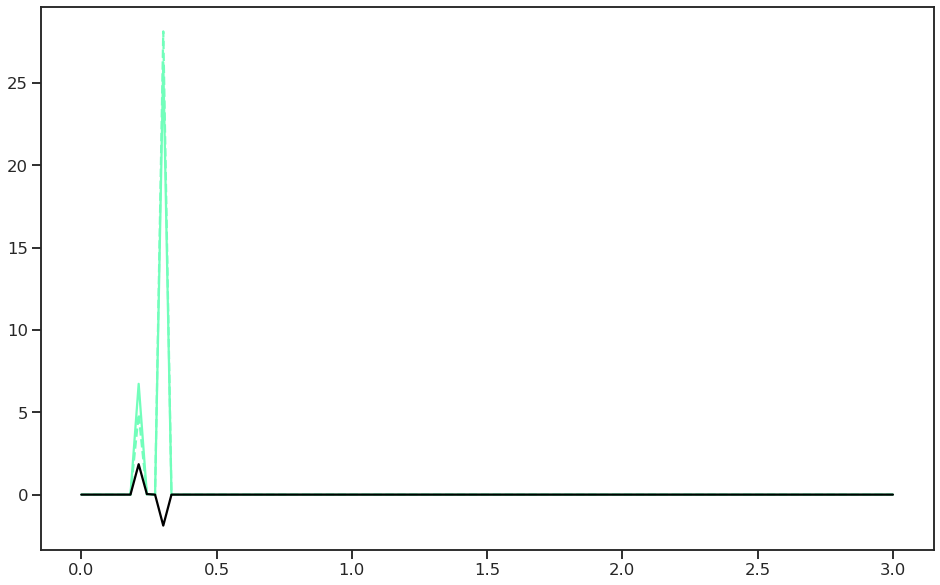

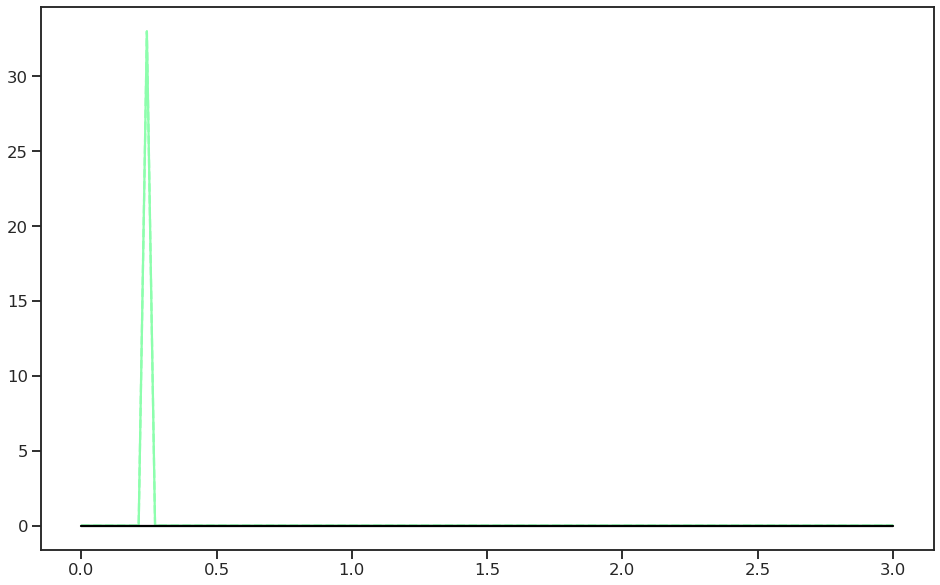

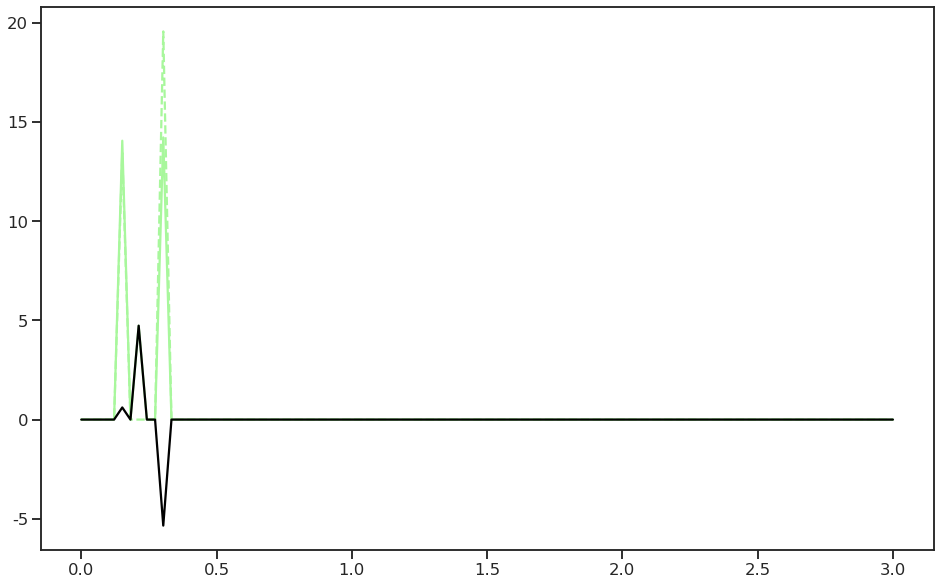

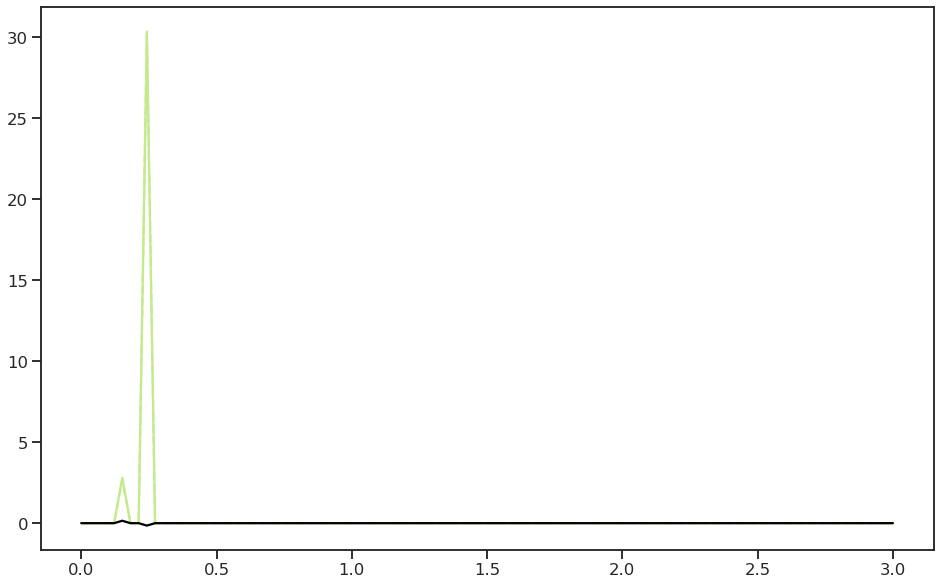

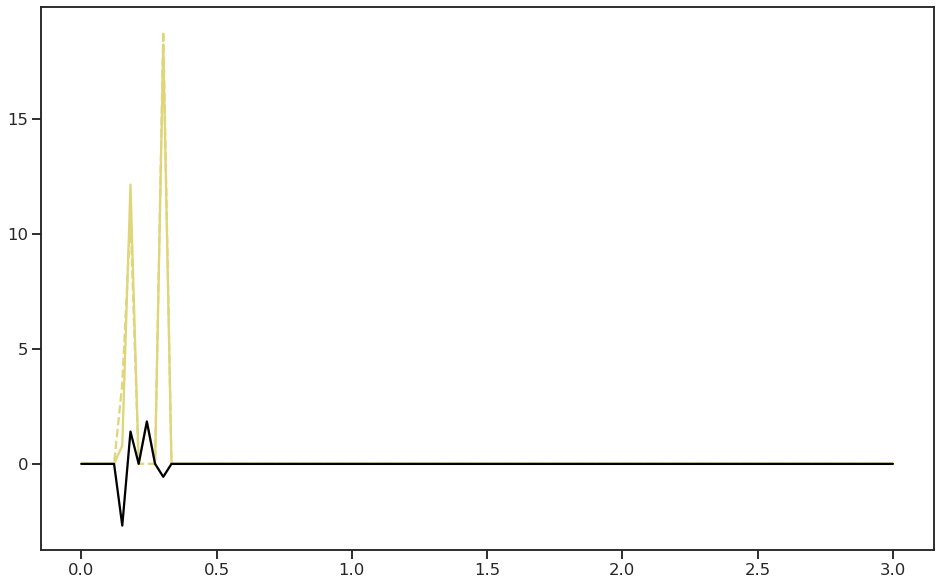

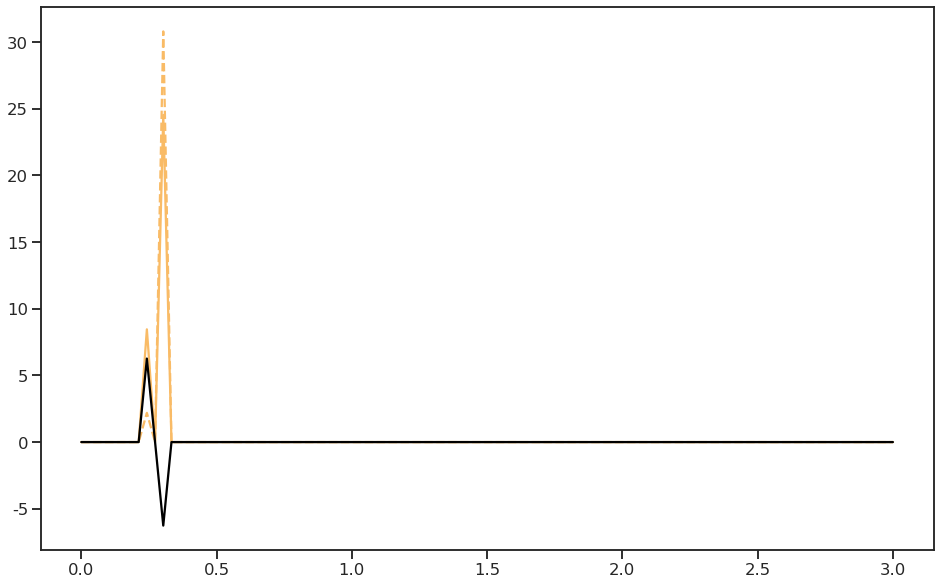

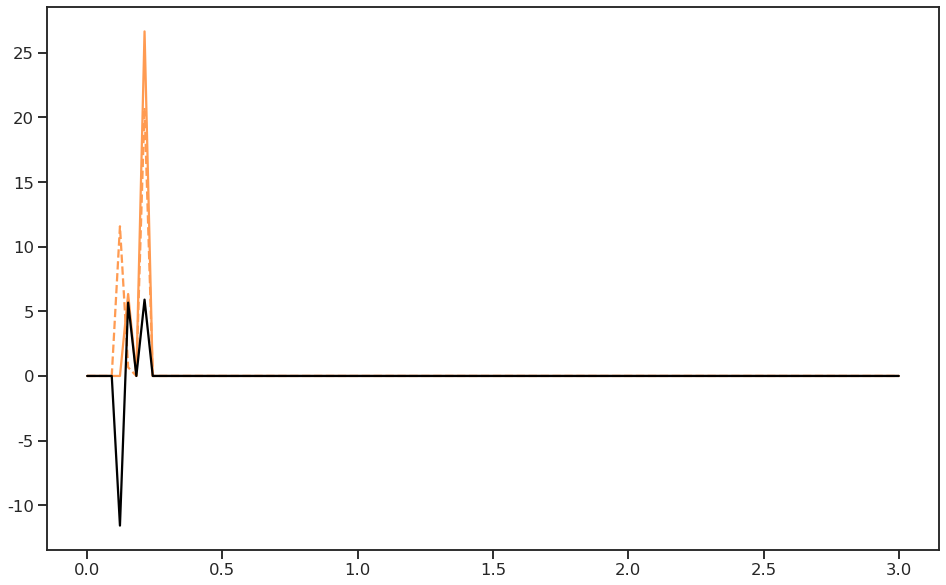

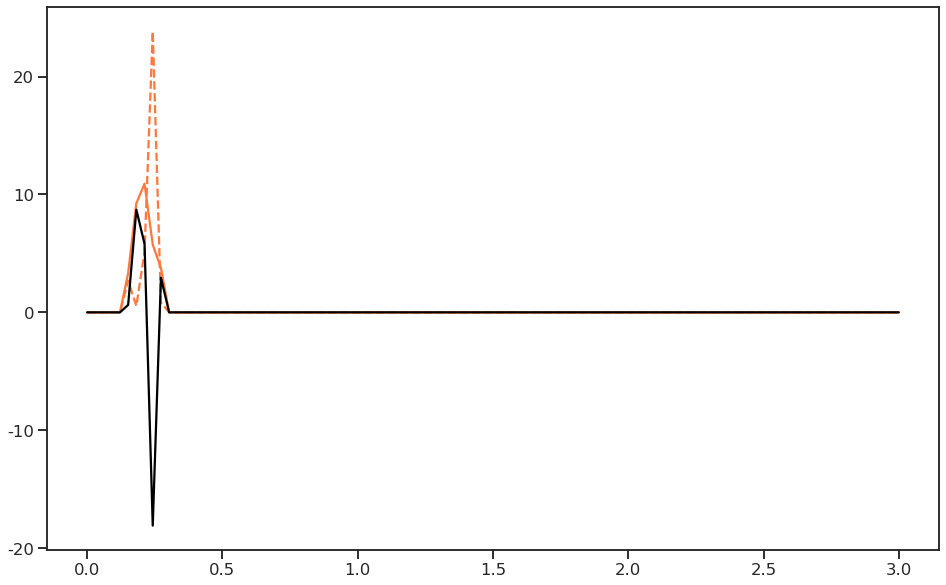

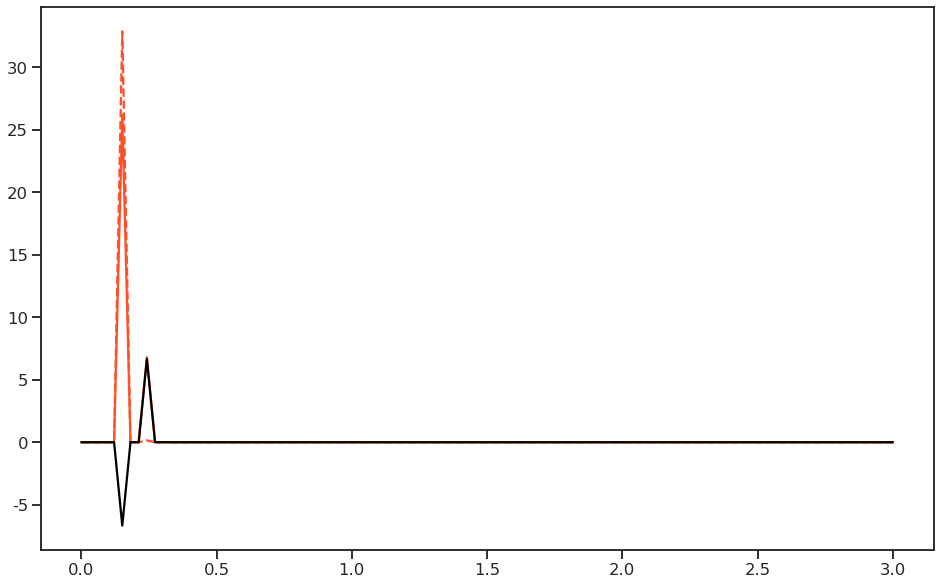

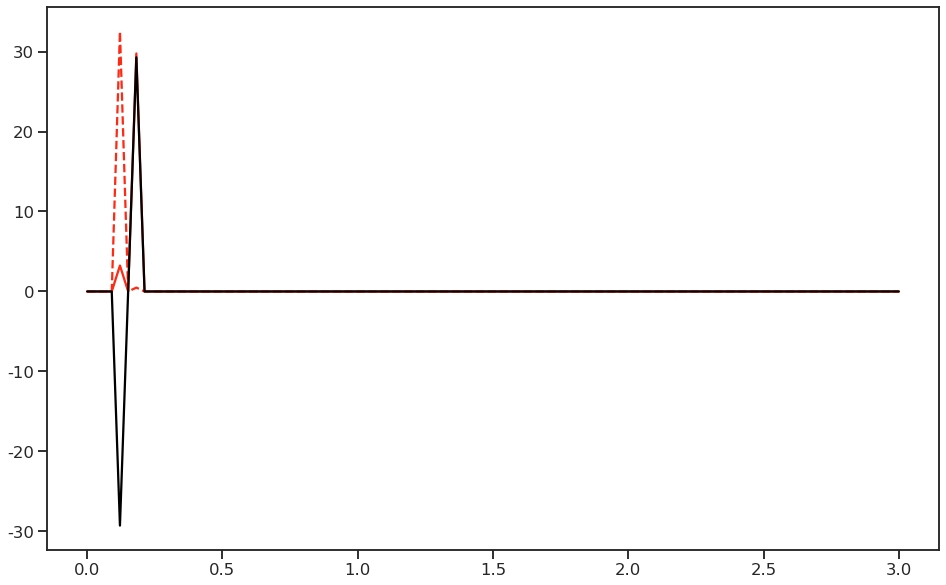

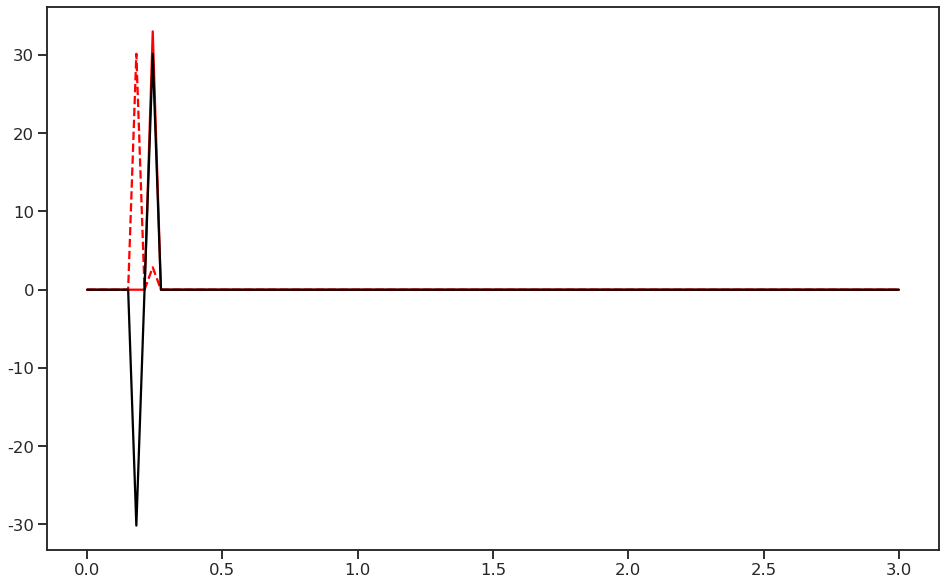

20


In [51]:
import random
plt.xlim(0,0.5)
color = iter(plt.cm.rainbow(np.linspace(0, 1, 20)))
for pix in pixgrids:
    p1=PriorUniverse1(ztest,pix,H0Planck,Om0Planck,2.7)
    p2=PriorUniverse2(ztest,pix,H0Planck,Om0Planck,2.7)
    p1_n=p1/jnp.trapz(p1,ztest)
    p2_n=p2/jnp.trapz(p2,ztest)
    diff=p1_n-p2_n
    if(jnp.trapz(p1,ztest)!=0):
        #print(diff)
        c=next(color)
        plt.plot(ztest,p1_n,c=c)
        plt.plot(ztest,p2_n,linestyle='--',c=c)
        plt.plot(ztest,diff,color='black')
        plt.show()
#plt.savefig("10k-9k_64.png")
print(plotnumber)

In [48]:
print(zgrid1[100]-zgrid1[99])
print(zgrid1[101]-zgrid1[100])
print(zgrid1[102]-zgrid1[101])

0.00015642928226261218
0.00015645338202215607
0.00015647748549455637
